In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Problem 1

To solve $\frac{dy}{dx} = f(x,y)$ with our regular RK4 integrator, at each time step, we compute the following:

$k_1 = hf(x_n,y_n)$\
$k_2 = hf(x_n+\frac{h}{2},y_n+\frac{k_1}{2})$\
$k_3 = hf(x_n+\frac{h}{2},y_n+\frac{k_2}{2})$\
$k_4 = hf(x_n+h,y_n+k_3)$

and our approximation of the value of the solution at $x_{n+1}$ is

$y_{n+1} = y_n + \frac{k_1}{6}+\frac{k_2}{3}+\frac{k_3}{3}+\frac{k_4}{6}+O(h^5)$

This is what the function rk4_step below is meant to do. We see that for 200 timesteps, we approximate the approximation pretty nicely, with an error on the order of $\sim 10^{-4}$.

But we can do better to cancel our leading order error in our approximation. If we allow ourselves to compute two smaller steps of half the size, we get the following:

$y(x+h) = y_{one\ step}+(h^5)\phi+O(h^6)$   (1)\
$y(x+h) = y_{two\ steps} + 2\cdot(\frac{h}{2})^5\phi+O(h^6)$   (2)

Where the factor of 2 on the leading error term in (2) is due to taking 2 steps. We can cancel the leading error term by subtracting 16 (2) from (1), and then solving for $y(x+h)$, which yields

$y(x+h) = y_{two\ steps} + \frac{y_{two steps}-y_{one step}}{15}+O(h^6)$,

so we win an order of error.

However, this second method needs more evaluation by stepsize, 11 to be precise (if we feed it the evaluation of $k_1$ from the single step like it is done below). To be fair, we can use both method using the same number of function evaluations, which needs to be lower by a factor 4/11 compared to the single step method. Even with the same number of evaluations, we can see that we are still more accurate by a factor $\sim10$ compared to the single step method.

<IPython.core.display.Javascript object>


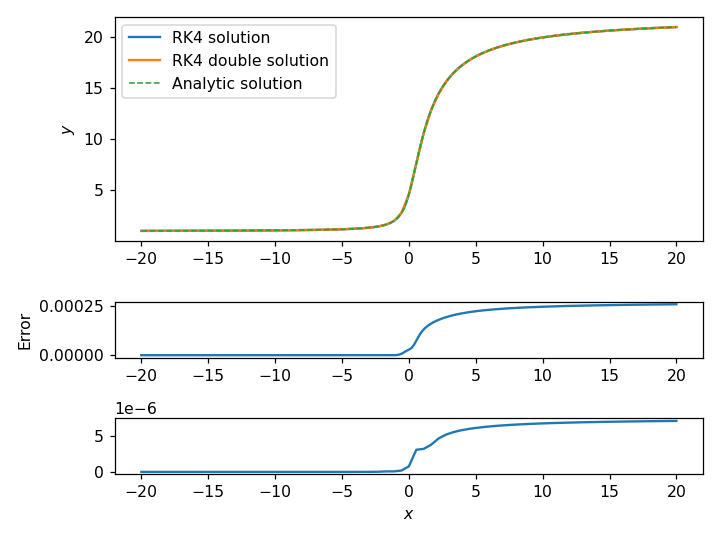

On average, the double stepsize method is about 37.0 times more accurate than the single stepsize


In [4]:
# defining RHS of ODE
def f(x,y):
    dydx = y/(1+x**2)
    return dydx

#analytical solution
def truesol(x):
    c0 = np.exp(np.arctan(x[0]))**-1
    y = c0*np.exp(np.arctan(x))
    return y

#regular rk4 integrator, but it has arguments that can be activated to give it a pre-computed k1, or its computed k1 to save one 
#funtion evaluation when using the double step method
def rk4_step(fun,x,y,h,k1=None,return_k1=False):
    
    if k1 is None: #when we compute a step form this point for the first time
        k1=fun(x,y)*h
    else: #when we already have the first function evaluation
        k1 = k1
    k2=h*fun(x+h/2,y+k1/2)
    k3=h*fun(x+h/2,y+k2/2)
    k4=h*fun(x+h,y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    
    if return_k1:
        return y+dy,k1
    else:
        return y+dy

# double step integrator
def rk4_stepd(fun,x,y,h):

    one_step,k1 = rk4_step(fun,x,y,h,return_k1=True) #when taking the first big step, we return
                                                        #1 such that we can use it for the next maller step
    two_steps = rk4_step(fun,x,y,h/2,k1=k1/2) # 1st part of the two small steps (k1 needs to be halved  because h is halved)
    two_steps = rk4_step(fun,x+h/2,two_steps,h/2) #2nd part
    delta = two_steps-one_step
    return two_steps+delta/15 #correction of the O(h^5) term

nsteps = 200 
nsteps_double = int(4/11*200) #the double step method uses 11 evals/step, and the simple step uses 4/step, so to be fair we use
                                #4/11 less evaluations for the double step method
y0=1 #init cond

#create necessary arrays and values for the integrators for each method
x_simple = np.linspace(-20,20,nsteps+1)
h_simple = np.median(np.diff(x_simple))

x_double = np.linspace(-20,20,nsteps_double+1)
h_double = np.median(np.diff(x_double))

y_simple = np.zeros(len(x_simple))
y_simple[0]=y0

y_double = np.zeros(len(x_double))
y_double[0]=y0

#solve with simple step
for i in range(len(x_simple)-1):
    y_simple[i+1] = rk4_step(f,x_simple[i],y_simple[i],h_simple)

#solve with double step
for i in range(len(x_double)-1):
    y_double[i+1] = rk4_stepd(f,x_double[i],y_double[i],h_double)
    
ytrue = truesol(x_simple)
ytrue_double = truesol(x_double)

fig,ax = plt.subplots(3,1,gridspec_kw={'height_ratios':[4,1,1]})
ax[0].plot(x_simple,y_simple,label = 'RK4 solution')
ax[0].plot(x_double,y_double,label = 'RK4 double solution')
ax[0].plot(x_simple,ytrue,linestyle = '--',linewidth = 1,label = 'Analytic solution')
ax[2].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].legend()
ax[1].plot(x_simple,np.abs(y_simple-ytrue))
ax[2].plot(x_double,np.abs(y_double-ytrue_double))
ax[1].set_ylabel('Error')
fig.tight_layout()

print('On average, the double stepsize method is about',round(np.abs(np.mean(y_simple-ytrue)/np.mean(y_double-ytrue_double)),0), 'times more accurate than the single stepsize')

# Problem 2


For this problem, the system of ODEs we want to solve is the following:

$\dot{y_1} = -y_1/\tau_1$\
$\dot{y_2} = y_1/\tau_1-y_2/\tau_2$\
$\dot{y_3} = y_2/\tau_2-y_3/\tau_3$\
$\vdots$\
$\dot{y_{14}} = y_{13}\tau_{13}-y_{14}/\tau_{14}$\
$\dot{y_{15}} = y_{14}/\tau_{14}$

Where the indices correspond to the i$^{th}$ element in the decay chain of U238. Each ODE represent the fact that each element has a rate in and a rate out. The rate in of an element corresponds to the rate out of the element above it in the chain. Hence the top and bottom elements (U238 and Pb206) only have a rate out and in, respectively.

When using Scipy's solver for this, we need to use the Radau method, because it is a stiff set of equations. The length scales of each ODE varies by many orders of magnitude. Hence, if we use the same stepsize for all ODEs, it will take forever to run and generate bad results.

In [77]:
#converting factors so that everything is in seconds
years = 365*24*60*60
days = years/365
hours = days/24
minutes = hours/60

#half lives array, I use infinity as a half life for lead 206 st its decaying term is 0
half_lives =[4.468e9*years, 24.1*days,6.7*hours,245.5e3*years,75.38e3*years,1600*years,
             3.8235*days,3.1*minutes,26.8*minutes,19.9*minutes,164.3e-6,22.3*years,5.015*years,
             138.376*days,np.inf]

#normalize with respect to the half life of U238
half_lives/=np.max(half_lives[:-1])

#def RHS of the system of ODE
def f(x,y,half_lives=half_lives):
    
    dydx = np.zeros(len(half_lives))
    
    dydx[0] = -y[0]/half_lives[0] #the RHS for U238 has no growth term
    
    for i in range(len(dydx)-1):
        dydx[i+1] = y[i]/half_lives[i]-y[i+1]/half_lives[i+1] #each other element has a growth and decay term
    return dydx

In [78]:
y0 = np.zeros(len(half_lives))
y0[0]=1

soln = integrate.solve_ivp(f,[0,5],y0,t_eval=np.linspace(0,5,2001),method='Radau') #solving with scipy using the stiff eqn solver

<IPython.core.display.Javascript object>


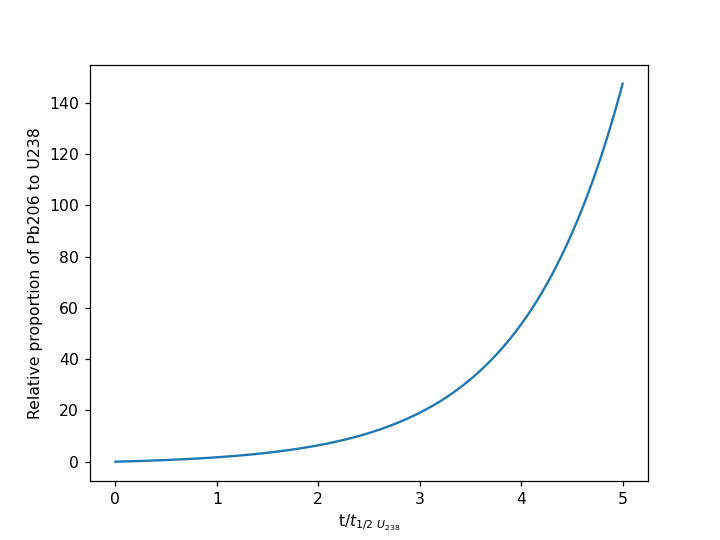

Text(0, 0.5, 'Relative proportion of Pb206 to U238')

In [79]:
fig,ax = plt.subplots()
ax.plot(soln.t,soln.y[-1]/soln.y[0])
ax.set_xlabel('t/$t_{1/2\ U_{238}}$')
ax.set_ylabel('Relative proportion of Pb206 to U238')

<IPython.core.display.Javascript object>


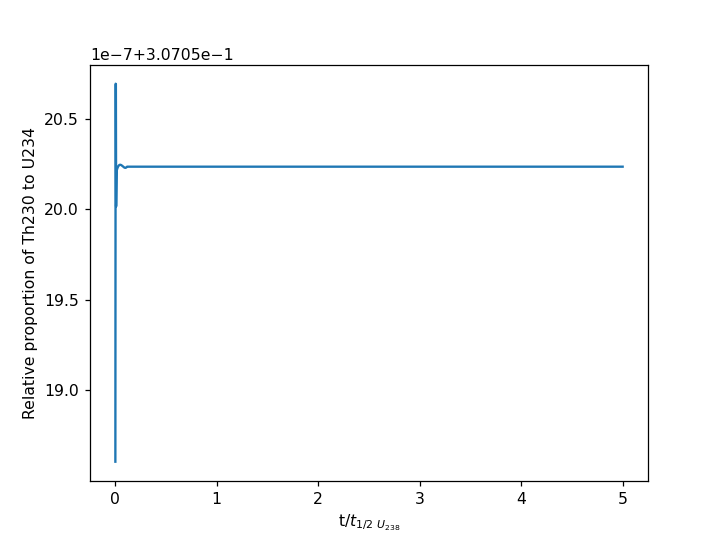

<ipython-input-80-f893dd3bda36>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(soln.t,soln.y[4]/soln.y[3])


Text(0, 0.5, 'Relative proportion of Th230 to U234')

In [80]:
fig,ax = plt.subplots()
ax.plot(soln.t,soln.y[4]/soln.y[3])
ax.set_xlabel('t/$t_{1/2\ U_{238}}$')
ax.set_ylabel('Relative proportion of Th230 to U234')

We see that the ratio of Pb206 to U238 makes sense: as time goes on, the U238 decays and eventually turns into Pb206 so the ratio starts near 0 and exponentially goes to infinity. As for the Th230 to U234 ratio, it oscillates a little bit at the start, and then stays pretty much constant over time scales of the half life of U238. This makes sense because over such time scales, there will only be trace amounts of both elements because they have similar half lives, hence, the ratio will be constant for long time scales. In fact, the final ratio at equilibrium of Th230 and U234 is the same if we change the half life of U238 in our solver above, since it only depends on the half-life of both these elements. It is worth noting that the transient solution of the ratio above changes when evaluating the solution at different steps (t_eval in the solver), but the equilibrium ratio stays the same. As a sanity check that everything works as its supposed to, we can test the solver with  an array of equal half-lives:


<IPython.core.display.Javascript object>


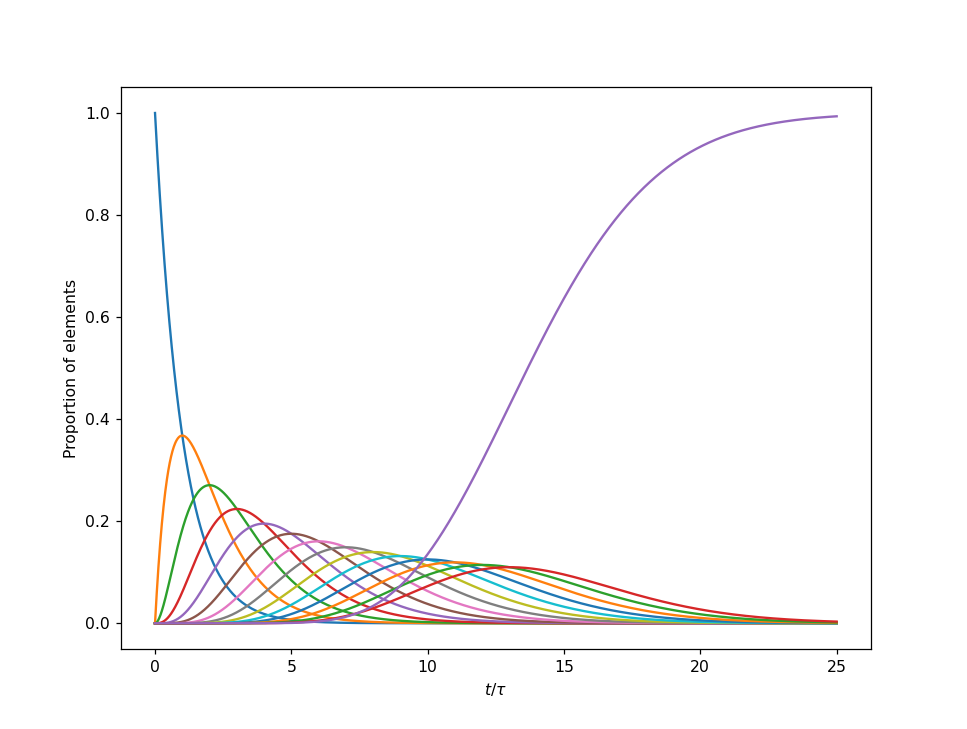

Text(0, 0.5, 'Proportion of elements')

In [87]:
y0 = np.zeros(len(half_lives))
y0[0]=1
half_lives_equal = half_lives
half_lives_equal[:-1] = 1

soln = integrate.solve_ivp(f,[0,25],y0,t_eval=np.linspace(0,25,2001),method='Radau',args = [half_lives_equal])
fig,ax = plt.subplots()
for sol in soln.y:
    ax.plot(soln.t,sol)
    
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel('Proportion of elements')

<font size="4">We see that this plot qualitatively makes sense, all elements decay into their subsequent elements in the chain, and eventually, the last product of the chain keeps rising until only that one is left.

# Problem 3

In [14]:
data = np.loadtxt('dish_zenith.txt') # load the data
x,y,z = data[:,0],data[:,1],data[:,2] #separate into x,y,z arrays

<IPython.core.display.Javascript object>


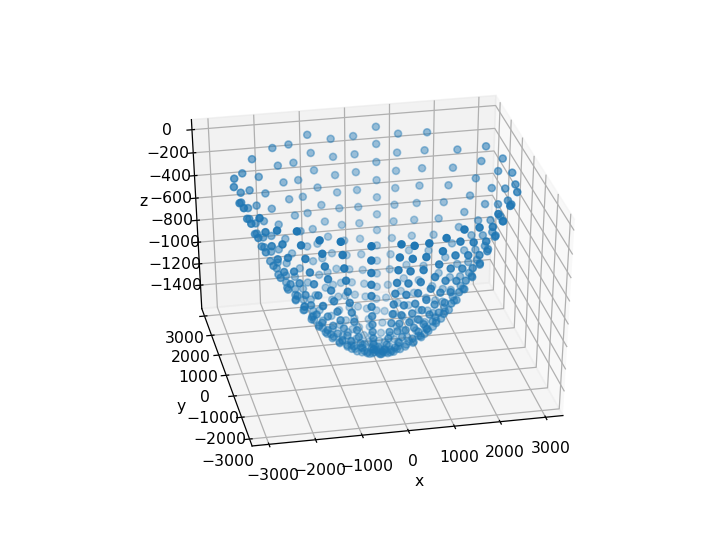

Text(0.5, 0, 'z')

In [17]:
#quick look at the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


We see that our points indeed make a paraboloid, now we need to fit the equation  of a paraboloid to this data.

The equation that describes this surface is $ z-z_0 = a((x-x_0)^2+(y-y_0)^2)$, which appears to be non-linear because some of the fit parameters are squared. However, we can expand this expression:

$ z = a(x^2-2xx_0+x_0^2+y^2-2yy_0+y_0^2)+z_0$

and rearrange it as

$ z = a(x^2+y^2)-2ax_0x-2ay_0y+(ax_0^2+ay_0^2+z_0)$

If we make the substitutions

$A'=a$\
$B = -2ax_0$\
$C = -2ay_0$\
$D = (ax_0^2+ay_0^2+z_0)$

we have z = $A'(x^2+y^2)+Bx+Cy+D$, which we can perform a linear-least squares fit on.

We will have $Z = Am$ where Z is the vector of the datapoints coordinates in z, A is the matrix with columns $1,x,y,$ and $x^2+y^2$, and m is the vector of fit parameters $(A',B,C,D)^T$ (A is the matrix and A' is the parameter, not to be confused)

We can perform our usual fit and get our mock parameters, than convert them back to the parameters of the paraboloid.

<IPython.core.display.Javascript object>


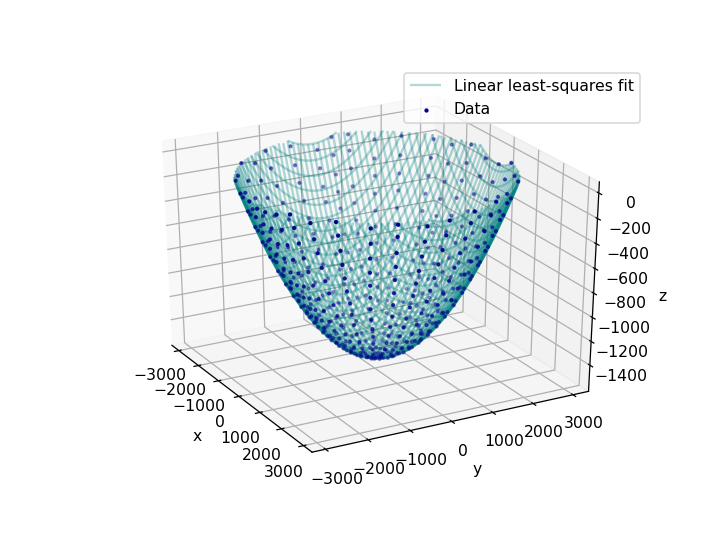

The fit parameters are a = 0.0002, x_0 = -1.36, y_0 = 58.22, z_0 = -1512.88
The estimated noise is 3.7683 mm, the best fit focal length is f = (1.4997+/-0.0002)m


In [94]:
#making the matrix associated with the new parameters

A = np.zeros([len(x),4])
A[:,0] = 1
A[:,1] = x
A[:,2] = y
A[:,3] = x**2+y**2

#carrying out the fit

lhs=A.T@A
rhs=A.T@z
mfit=np.linalg.inv(lhs)@rhs
pred=A@mfit

#converting the fit parameters to the actual parameters in the paraboloid equation

a = mfit[-1]
x0 = mfit[1]/(-2*a)
y0 = mfit[2]/(-2*a)
z0 = mfit[0]-a*x0**2-a*y0**2

#plotting the fit and the data together to know everything makes sense
X,Y = np.linspace(x.min(),x.max(),len(x)),np.linspace(y.min(),y.max(),len(x))
X, Y = np.meshgrid(X,Y)
Z = a*((X-x0)**2+(Y-y0)**2)+z0
Z[Z>np.max(z)] = np.nan

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z,alpha = 0.3,color = 'teal', label = 'Linear least-squares fit')
ax.scatter(x,y,z, color = 'darkblue', s = 3, label = 'Data')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

z_fit = a*((x-x0)**2+(y-y0)**2)+z0
residuals = z-z_fit
noise = np.std(residuals)

a_err = np.sqrt(np.diag(np.linalg.inv(lhs)))[-1]

f=1/(4*a)*1e-3
f_err = a_err/a*f

print('The fit parameters are a = {}, x_0 = {}, y_0 = {}, z_0 = {}'.format(round(a,4),round(x0,2),round(y0,2),round(z0,2)))
print('The estimated noise is {} mm, the best fit focal length is f = ({}+/-{})m'.format(round(noise,4),round(f,4),round(f_err,4)))

We can see that our fit did work, the plotted surface according to our fit parameters seems to want to stick to our datapoints. It is a little harder to see in 3D, but it does the job. We can estimate the noise by taking the standard deviation of the residuals between the $z$ coordinate of our datapoints and the $z$ coordinates of our fit evaluated at the same $x,y$. 

We can compute our best guess for the focal length. We do not care about $x_0,y_0,z_0$ in this part because they only translate our dish in space. Hence, we can represent the dish centered at $(0,0,0)$ by writing it as $ z = \frac{x^2+y^2}{4f}$, where $f$ is the focal length of our dish. We know from our fit that the centered paraboloid can be expressed as $z = a(x^2+y^2)$, so we can equate the two and solve for $f$: $f = 1/4a$. To compute the error on the focal length, we can propagate the error (the relative uncertainty gets carried on$^1$),  on the parameter $a$, which can be obtained from the square root of the diagonal of the inverted matrix that corresponds to the LHS of our fit equation. The error on a is then just the entry in the covariance matrix corresponding to the row of that parameter.
    
We then obtain that the focal length is $f = (1.4997\pm0.0002)m$, which is really close to what it was supposed to be.

$^1$Measurements and Their Uncertainties : A Practical Guide to Modern Error Analysis, Hughes, Hase, 2010